In [1]:
# !pip3 install pillow

In [2]:
import tensorflow as tf;
import pandas as pd
from pathlib import Path
import PIL
from PIL import Image

2024-11-09 22:59:56.883539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731173396.901845   82875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731173396.910471   82875 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 22:59:56.932499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# downloading dataset: Chicago's Data Portal

tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership_extracted'

In [6]:
path = Path("datasets/ridership_extracted/ridership/ridership.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  
df = df.drop_duplicates()  

In [7]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


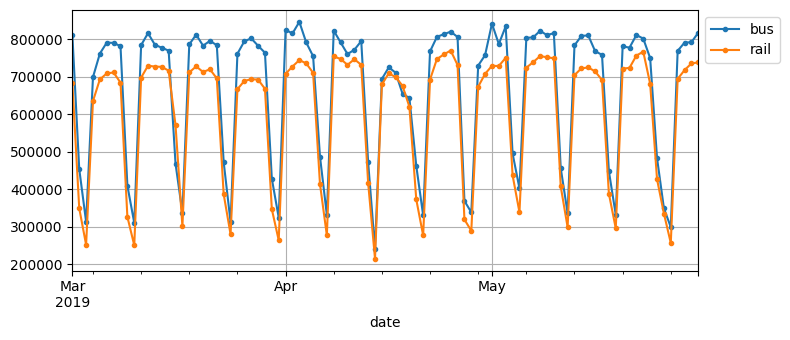

In [8]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()  
save_fig("daily_ridership_plot") 
plt.show()

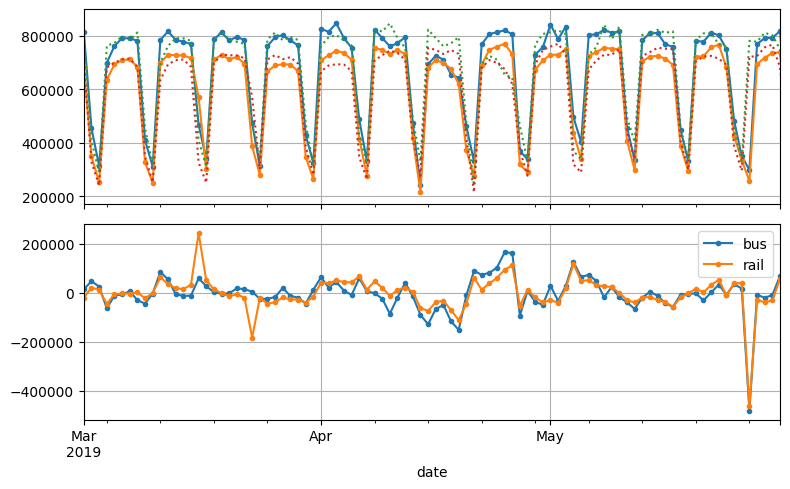

In [9]:
# try naive forecasting

diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

/tmp/ipykernel_82875/1271244895.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.select_dtypes(include=['number']).resample('M').mean()  # monthly mean only for numeric columns


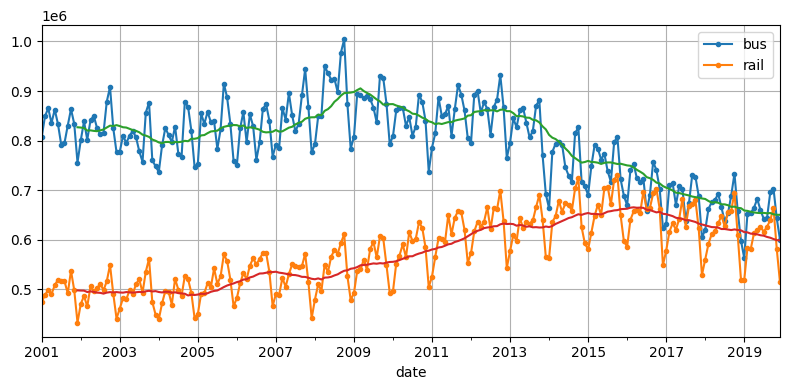

In [11]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include=['number']).resample('M').mean()  # monthly mean only for numeric columns
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")
plt.show()


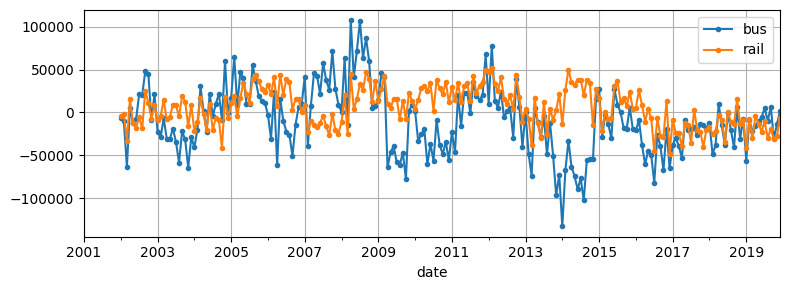

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

### THE ARMA MODEL FAMILY (AUTOREGRESSIVE MOVING AVERAGE)

$$
\hat{y}(t) = c + \sum_{i=1}^{p} \phi_i y(t - i) + \sum_{j=1}^{q} \theta_j \epsilon(t - j)
$$

where:

- $ \hat{y}(t) $ is the forecasted value at time $ t $,
- $ c $ is a constant term,
- $ \phi_i $ are the parameters for the autoregressive (AR) part (for $ i = 1, 2, \ldots, p $),
- $ \theta_j $ are the parameters for the moving average (MA) part (for $ j = 1, 2, \ldots, q $),
- $ y(t - i) $ are the past values of the series,
- $ \epsilon(t - j) $ are the past forecast errors (white noise),
- $ p $ is the order of the autoregressive part,
- $ q $ is the order of the moving average part.


In [13]:
# !pip install statsmodels


In [14]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [15]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

/tmp/ipykernel_82875/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_82875/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_82875/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_82875/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as posi

In [16]:
mae

np.float64(32040.720089453378)

#### PREPARING DATA FOR ML MODELS

In [17]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

I0000 00:00:1731173403.945646   82875 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-11-09 23:00:04.146178: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [18]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2024-11-09 23:00:04.170223: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-11-09 23:00:04.175212: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-09 23:00:04.181927: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-09 23:00:04.191564: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [20]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [21]:
# SCALING OF DATA
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [22]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

#### FORECASTING USING A LINEAR MODEL



In [23]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

/home/anson/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
 4/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1255 - mae: 0.3960

I0000 00:00:1731173405.692538   82944 service.cc:148] XLA service 0x7f68a4007fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731173405.692627   82944 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-11-09 23:00:05.710913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731173405.741590   82944 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731173405.864657   82944 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0863 - mae: 0.3331 - val_loss: 0.0202 - val_mae: 0.1663
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.1413 - val_loss: 0.0073 - val_mae: 0.0923
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mae: 0.1062 - val_loss: 0.0068 - val_mae: 0.0908
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mae: 0.0939 - val_loss: 0.0059 - val_mae: 0.0814
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - mae: 0.0888 - val_loss: 0.0054 - val_mae: 0.0769
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0791 - val_loss: 0.0052 - val_mae: 0.0754
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0768 - val_loss: 0.0048 - val_mae: 0.0697
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0813 - val_loss: 0.0046 - val_mae: 0.0683
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.

In [24]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0393


37898.68205785751

#### FORECASTING USING SIMPLE RNN

In [25]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/home/anson/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [27]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.8860 - mae: 1.3490 - val_loss: 0.0627 - val_mae: 0.3043
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 - mae: 0.2841 - val_loss: 0.0473 - val_mae: 0.2469
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368 - mae: 0.1971 - val_loss: 0.0215 - val_mae: 0.1504
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - mae: 0.1726 - val_loss: 0.0204 - val_mae: 0.1518
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mae: 0.1672 - val_loss: 0.0200 - val_mae: 0.1470
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208 - mae: 0.1711 - val_loss: 0.0195 - val_mae: 0.1441
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - mae: 0.1635 - val_loss: 0.0188 - val_mae: 0.1434
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - mae: 0.1664 - val_loss: 0.0182 - val_mae: 0.1424
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.01

102804.85451221466

In [28]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

#### DEEP RNNs

In [29]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [30]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0355 - mae: 0.2044 - val_loss: 0.0034 - val_mae: 0.0636
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - mae: 0.0786 - val_loss: 0.0027 - val_mae: 0.0511
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - mae: 0.0648 - val_loss: 0.0030 - val_mae: 0.0524
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0587 - val_loss: 0.0030 - val_mae: 0.0521
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0621 - val_loss: 0.0021 - val_mae: 0.0381
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0564 - val_loss: 0.0023 - val_mae: 0.0434
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0562 - val_loss: 0.0025 - val_mae: 0.0449
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - mae: 0.0590 - val_loss: 0.0048 - val_mae: 0.0804
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

31796.395778656006

#### FORECASTING MULTIVARIATE TIME SERIES

In [31]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [32]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [33]:
import numpy as np
mulvar_train = mulvar_train.astype(np.float32)
mulvar_valid = mulvar_valid.astype(np.float32)


In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [35]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/home/anson/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0703 - mae: 0.2800 - val_loss: 0.0022 - val_mae: 0.0535
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0487 - val_loss: 0.0016 - val_mae: 0.0461
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0394 - val_loss: 0.0014 - val_mae: 0.0434
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0366 - val_loss: 0.0015 - val_mae: 0.0458
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0399 - val_loss: 9.1660e-04 - val_mae: 0.0333
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0335 - val_loss: 0.0010 - val_mae: 0.0360
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0343 - val_loss: 7.8255e-04 - val_mae: 0.0290
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mae: 0.0352 - val_loss: 6.8963e-04 - val_mae: 0.0258
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

23708.64525437355

In [37]:
tf.keras.backend.clear_session()

In [38]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/home/anson/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1287 - mae: 0.3638 - val_loss: 0.0052 - val_mae: 0.0779
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mae: 0.0748 - val_loss: 0.0015 - val_mae: 0.0374
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0520 - val_loss: 0.0014 - val_mae: 0.0372
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0479 - val_loss: 0.0012 - val_mae: 0.0326
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mae: 0.0459 - val_loss: 0.0015 - val_mae: 0.0402
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0439 - val_loss: 0.0010 - val_mae: 0.0311
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0430 - val_loss: 0.0012 - val_mae: 0.0346
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0445 - val_loss: 9.7178e-04 - val_mae: 0.0308
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae

25068.71521472931

In [39]:
tf.keras.backend.clear_session()

In [40]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

np.float32(43441.625)

#### FORECASTING SEVERAL TIME STEPS AHEAD

In [41]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [42]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [43]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.2299 - mae: 0.5460 - val_loss: 0.0314 - val_mae: 0.1945
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251 - mae: 0.1752 - val_loss: 0.0151 - val_mae: 0.1363
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.1380 - val_loss: 0.0115 - val_mae: 0.1184
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - mae: 0.1249 - val_loss: 0.0094 - val_mae: 0.1071
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.1127 - val_loss: 0.0076 - val_mae: 0.0965
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - mae: 0.1052 - val_loss: 0.0065 - val_mae: 0.0891
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0984 - val_loss: 0.0055 - val_mae: 0.0828
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - mae: 0.0918 - val_loss: 0.0049 - val_mae: 0.0777
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

34449.51772689819

In [45]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


In [46]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [47]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

#### FORECASTING USING A SEQ-2-SEQ MODEL

In [48]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [49]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [51]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [52]:
tf.keras.backend.clear_session()

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 2s 25ms/step - loss: 0.1379 - mae: 0.3955

2024-11-09 23:08:16.573043: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
/home/anson/miniconda3/envs/tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-09 23:08:16.573119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1359 - mae: 0.3917 - val_loss: 0.0177 - val_mae: 0.1426
Epoch 2/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148 - mae: 0.1347  

2024-11-09 23:08:17.083366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:17.083444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - mae: 0.1257 - val_loss: 0.0093 - val_mae: 0.0993
Epoch 3/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0074 - mae: 0.0931

2024-11-09 23:08:17.465412: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 23:08:17.465484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:17.465526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:17.510068: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:17.510141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0075 - mae: 0.0912 - val_loss: 0.0063 - val_mae: 0.0777
Epoch 4/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0052 - mae: 0.0757

2024-11-09 23:08:20.403573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:20.403647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:20.448344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:20.448415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - mae: 0.0742 - val_loss: 0.0055 - val_mae: 0.0701
Epoch 5/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0036 - mae: 0.0602

2024-11-09 23:08:20.858669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:20.858775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:20.906777: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:20.906863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - mae: 0.0653 - val_loss: 0.0049 - val_mae: 0.0646
Epoch 6/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0034 - mae: 0.0568

2024-11-09 23:08:21.310135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:21.310210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:21.353775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:21.353859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - mae: 0.0613 - val_loss: 0.0045 - val_mae: 0.0595
Epoch 7/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0031 - mae: 0.0550

2024-11-09 23:08:21.766326: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 23:08:21.766383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:21.766415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:21.814178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:21.814279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0042 - mae: 0.0599 - val_loss: 0.0047 - val_mae: 0.0628
Epoch 8/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0032 - mae: 0.0524

2024-11-09 23:08:22.277715: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:22.277815: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:22.339787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:22.339864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - mae: 0.0579 - val_loss: 0.0044 - val_mae: 0.0595
Epoch 9/500


2024-11-09 23:08:22.740957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:22.741014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:22.798168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:22.798237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0567 - val_loss: 0.0041 - val_mae: 0.0562
Epoch 10/500


2024-11-09 23:08:23.227096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:23.227154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:23.278277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:23.278345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038 - mae: 0.0560 - val_loss: 0.0041 - val_mae: 0.0563
Epoch 11/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0030 - mae: 0.0528

2024-11-09 23:08:23.821284: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:23.821367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:23.866588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:23.866655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0557 - val_loss: 0.0043 - val_mae: 0.0584
Epoch 12/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0027 - mae: 0.0495

2024-11-09 23:08:24.259080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:24.259174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:24.307151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:24.307219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - mae: 0.0553 - val_loss: 0.0042 - val_mae: 0.0571
Epoch 13/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0028 - mae: 0.0502

2024-11-09 23:08:24.744434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:24.744507: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:24.789330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:24.789446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0545 - val_loss: 0.0041 - val_mae: 0.0558
Epoch 14/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - mae: 0.0463

2024-11-09 23:08:25.172695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:25.172766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:25.220724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:25.220791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mae: 0.0541 - val_loss: 0.0042 - val_mae: 0.0569
Epoch 15/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0024 - mae: 0.0462

2024-11-09 23:08:25.633708: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 23:08:25.633764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:25.633796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:25.679538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:25.679607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0533 - val_loss: 0.0043 - val_mae: 0.0583
Epoch 16/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0028 - mae: 0.0475

2024-11-09 23:08:26.073662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:26.073773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:26.118994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:26.119063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0529 - val_loss: 0.0039 - val_mae: 0.0540
Epoch 17/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0025 - mae: 0.0481

2024-11-09 23:08:26.517100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:26.517201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:26.568228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:26.568295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0535 - val_loss: 0.0040 - val_mae: 0.0540
Epoch 18/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0027 - mae: 0.0499

2024-11-09 23:08:26.970992: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:26.971083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:27.019347: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:27.019416: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0529 - val_loss: 0.0039 - val_mae: 0.0539
Epoch 19/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0025 - mae: 0.0479

2024-11-09 23:08:27.401573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:27.401671: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:27.449310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:27.449381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0524 - val_loss: 0.0041 - val_mae: 0.0565
Epoch 20/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0025 - mae: 0.0455

2024-11-09 23:08:27.868354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:27.868434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:27.916234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:27.916330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0520 - val_loss: 0.0040 - val_mae: 0.0552
Epoch 21/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0025 - mae: 0.0454

2024-11-09 23:08:28.314764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:28.314839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:28.362516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:28.362583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0516 - val_loss: 0.0040 - val_mae: 0.0540
Epoch 22/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0026 - mae: 0.0477

2024-11-09 23:08:28.777967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:28.778043: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:28.825686: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:28.825787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0519 - val_loss: 0.0040 - val_mae: 0.0548
Epoch 23/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0024 - mae: 0.0451

2024-11-09 23:08:29.233285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:29.233359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:29.281683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:29.281751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0516 - val_loss: 0.0041 - val_mae: 0.0559
Epoch 24/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0027 - mae: 0.0487

2024-11-09 23:08:29.687279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:29.687368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:29.734227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:29.734317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0520 - val_loss: 0.0039 - val_mae: 0.0531
Epoch 25/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0025 - mae: 0.0473

2024-11-09 23:08:30.136483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:30.136566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:30.184616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:30.184688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - mae: 0.0516 - val_loss: 0.0040 - val_mae: 0.0548
Epoch 26/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0026 - mae: 0.0477

2024-11-09 23:08:30.616510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:30.616589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:30.665393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:30.665480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0514 - val_loss: 0.0040 - val_mae: 0.0552
Epoch 27/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0027 - mae: 0.0461

2024-11-09 23:08:31.116925: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:31.117006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:31.165234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:31.165305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0504 - val_loss: 0.0039 - val_mae: 0.0530
Epoch 28/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0023 - mae: 0.0440

2024-11-09 23:08:31.593309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:31.593388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:31.640192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:31.640281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0504 - val_loss: 0.0039 - val_mae: 0.0538
Epoch 29/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0024 - mae: 0.0460

2024-11-09 23:08:32.091296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:32.091385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:32.155003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:32.155259: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0506 - val_loss: 0.0038 - val_mae: 0.0517
Epoch 30/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0026 - mae: 0.0480

2024-11-09 23:08:32.570244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:32.570313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:32.623821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:32.623910: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - mae: 0.0511 - val_loss: 0.0039 - val_mae: 0.0525
Epoch 31/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0023 - mae: 0.0443

2024-11-09 23:08:33.063502: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 23:08:33.063580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:33.063623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:33.114613: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:33.114680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0500 - val_loss: 0.0037 - val_mae: 0.0509
Epoch 32/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0023 - mae: 0.0461

2024-11-09 23:08:33.534681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:33.534750: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:33.581765: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:33.581835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0511 - val_loss: 0.0038 - val_mae: 0.0521
Epoch 33/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0445

2024-11-09 23:08:34.002668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:34.002741: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:34.048047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:34.048138: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0502 - val_loss: 0.0038 - val_mae: 0.0519
Epoch 34/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0025 - mae: 0.0469

2024-11-09 23:08:34.417148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:34.417239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:34.463388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:34.463455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0510
Epoch 35/500


2024-11-09 23:08:34.878471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:34.878582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:34.931389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:34.931480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0039 - val_mae: 0.0528
Epoch 36/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0024 - mae: 0.0457

2024-11-09 23:08:35.514789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:35.514924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:35.584219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:35.584313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0509
Epoch 37/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0026 - mae: 0.0481

2024-11-09 23:08:35.975257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:35.975354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:36.029082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:36.029153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0038 - val_mae: 0.0514
Epoch 38/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0025 - mae: 0.0459

2024-11-09 23:08:36.413331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:36.413409: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:36.463859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:36.464003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0505 - val_loss: 0.0038 - val_mae: 0.0511
Epoch 39/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0024 - mae: 0.0447

2024-11-09 23:08:36.856357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:36.856451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:36.906772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:36.906973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0500 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 40/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0022 - mae: 0.0438

2024-11-09 23:08:37.376077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:37.376160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:37.429869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:37.429968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0491 - val_loss: 0.0038 - val_mae: 0.0516
Epoch 41/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0023 - mae: 0.0440

2024-11-09 23:08:37.866590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:37.866684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:37.929787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:37.929870: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0038 - val_mae: 0.0511
Epoch 42/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0025 - mae: 0.0456

2024-11-09 23:08:38.359530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:38.359629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:38.409673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:38.409794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0038 - val_mae: 0.0516
Epoch 43/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0023 - mae: 0.0431

2024-11-09 23:08:38.811278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:38.811384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:38.865971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:38.866049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 44/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0022 - mae: 0.0440

2024-11-09 23:08:39.278358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:39.278429: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:39.325328: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:39.325395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0491 - val_loss: 0.0038 - val_mae: 0.0521
Epoch 45/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0021 - mae: 0.0419

2024-11-09 23:08:39.730914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:39.730990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:39.779954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:39.780024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0038 - val_mae: 0.0517
Epoch 46/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - mae: 0.0429

2024-11-09 23:08:40.204324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:40.204398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:40.252346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:40.252434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0037 - val_mae: 0.0508
Epoch 47/500
 2/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0462  

2024-11-09 23:08:40.639837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:40.639905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:40.692187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:40.692280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0499 - val_loss: 0.0037 - val_mae: 0.0501
Epoch 48/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - mae: 0.0455

2024-11-09 23:08:41.089102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:41.089183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:41.140592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:41.140681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0498
Epoch 49/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0025 - mae: 0.0457

2024-11-09 23:08:41.539185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:41.539257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:41.587300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:41.587386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0511
Epoch 50/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0026 - mae: 0.0496

2024-11-09 23:08:41.999122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:41.999216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:42.046876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:42.046954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0501
Epoch 51/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - mae: 0.0467

2024-11-09 23:08:42.445047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:42.445150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:42.503840: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:42.503912: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0500 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 52/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0028 - mae: 0.0496

2024-11-09 23:08:42.900010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:42.900109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:42.949496: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:42.949587: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0496 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 53/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0021 - mae: 0.0424

2024-11-09 23:08:43.337228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:43.337321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:43.385626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:43.385696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0504
Epoch 54/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0024 - mae: 0.0473

2024-11-09 23:08:43.778587: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:43.778649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:43.834323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:43.834463: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0490 - val_loss: 0.0037 - val_mae: 0.0505
Epoch 55/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0021 - mae: 0.0418

2024-11-09 23:08:44.222695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:44.222886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:44.280234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:44.280302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0038 - val_mae: 0.0517
Epoch 56/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0023 - mae: 0.0423

2024-11-09 23:08:44.680449: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:44.680529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:44.730107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:44.730179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0504
Epoch 57/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0026 - mae: 0.0482

2024-11-09 23:08:45.147220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:45.147312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:45.195772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:45.195844: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0503 - val_loss: 0.0036 - val_mae: 0.0496
Epoch 58/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0026 - mae: 0.0485

2024-11-09 23:08:45.574233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:45.574305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:45.620294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:45.620364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 59/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0022 - mae: 0.0420

2024-11-09 23:08:46.046872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:46.046973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:46.096013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:46.096087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.0497
Epoch 60/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0024 - mae: 0.0460

2024-11-09 23:08:46.486684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:46.486758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:46.534353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:46.534455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0495
Epoch 61/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0026 - mae: 0.0475

2024-11-09 23:08:46.912526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:46.912623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:46.963028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:46.963097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0037 - val_mae: 0.0512
Epoch 62/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0027 - mae: 0.0523

2024-11-09 23:08:47.360465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:47.360541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0504 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 63/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0030 - mae: 0.0515

2024-11-09 23:08:47.824790: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 23:08:47.824847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:47.824879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:47.871903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:47.871970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 64/500


2024-11-09 23:08:48.332163: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:48.332289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:48.397696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:48.397840: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - mae: 0.0516 - val_loss: 0.0036 - val_mae: 0.0494
Epoch 65/500


2024-11-09 23:08:48.909357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:48.909484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:48.973527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:48.973627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0495
Epoch 66/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0022 - mae: 0.0430

2024-11-09 23:08:49.462759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:49.462876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:49.531934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:49.532194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0505
Epoch 67/500


2024-11-09 23:08:49.958085: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:49.958284: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:50.023535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:50.023654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0493
Epoch 68/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0023 - mae: 0.0440

2024-11-09 23:08:50.485550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:50.485620: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:50.534511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:50.534580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0494
Epoch 69/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0023 - mae: 0.0447

2024-11-09 23:08:50.914456: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:50.914529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:50.970242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:50.970309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.0493
Epoch 70/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0021 - mae: 0.0427

2024-11-09 23:08:51.413091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:51.413164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:51.457701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:51.457774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0493
Epoch 71/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - mae: 0.0450

2024-11-09 23:08:51.860525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:51.860622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:51.911390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:51.911460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0036 - val_mae: 0.0493
Epoch 72/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - loss: 0.0021 - mae: 0.0440

2024-11-09 23:08:52.345038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:52.345143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:52.395813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:52.395884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0037 - val_mae: 0.0497
Epoch 73/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0023 - mae: 0.0426

2024-11-09 23:08:55.510792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:55.510889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:55.569498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:55.569601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0496
Epoch 74/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0025 - mae: 0.0471

2024-11-09 23:08:55.995998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:55.996094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 75/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0027 - mae: 0.0531

2024-11-09 23:08:56.497724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:56.497807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:56.545994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:56.546068: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 76/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0423

2024-11-09 23:08:56.985214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:56.985293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:57.032432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:57.032501: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0037 - val_mae: 0.0506
Epoch 77/500
 2/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mae: 0.0425  

2024-11-09 23:08:57.433902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:57.433974: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:57.484826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:57.484927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0036 - val_mae: 0.0497
Epoch 78/500


2024-11-09 23:08:57.956525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:57.956644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:58.022786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 79/500


2024-11-09 23:08:58.533901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:58.533979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 80/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0021 - mae: 0.0431

2024-11-09 23:08:59.064936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:59.065077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:59.112294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:59.112368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0498
Epoch 81/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0024 - mae: 0.0471

2024-11-09 23:08:59.475921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:59.476014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:59.522920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:59.523024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 82/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0021 - mae: 0.0437

2024-11-09 23:08:59.887585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:59.887657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:08:59.933315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:08:59.933385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 83/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0025 - mae: 0.0443

2024-11-09 23:09:00.304235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:00.304324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:00.350159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:00.350227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 84/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0022 - mae: 0.0440

2024-11-09 23:09:00.726366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:00.773274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:00.773343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 85/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0021 - mae: 0.0418

2024-11-09 23:09:01.176834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:01.176929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:01.224660: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:01.224732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 86/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0022 - mae: 0.0432

2024-11-09 23:09:01.633948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:01.634074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 87/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0023 - mae: 0.0441

2024-11-09 23:09:02.106179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:02.106256: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:02.152913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:02.152982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0491
Epoch 88/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0025 - mae: 0.0475

2024-11-09 23:09:02.554108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:02.554182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:02.600954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:02.601031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 89/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0024 - mae: 0.0452

2024-11-09 23:09:02.994985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:02.995084: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:03.045596: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:03.045668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 90/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0021 - mae: 0.0434

2024-11-09 23:09:03.442391: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:03.442492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:03.491849: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:03.491930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 91/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0025 - mae: 0.0431

2024-11-09 23:09:03.891184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:03.891279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:03.941738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:03.941821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 92/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0026 - mae: 0.0445

2024-11-09 23:09:04.340233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:04.340308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:04.386786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:04.386885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0475 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 93/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0020 - mae: 0.0407

2024-11-09 23:09:04.790550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:04.790625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:04.836725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:04.836794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0036 - val_mae: 0.0491
Epoch 94/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0025 - mae: 0.0462

2024-11-09 23:09:05.230047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:05.230119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:05.278853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:05.278925: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 95/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0025 - mae: 0.0436

2024-11-09 23:09:05.668432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:05.718796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:05.718886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0482
Epoch 96/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0022 - mae: 0.0431

2024-11-09 23:09:06.102758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:06.102885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:06.156087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:06.156157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0037 - val_mae: 0.0504
Epoch 97/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0021 - mae: 0.0407

2024-11-09 23:09:06.556039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:06.556112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:06.605664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:06.605736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 98/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0026 - mae: 0.0473

2024-11-09 23:09:06.989529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:06.989622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:07.033309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:07.033382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 99/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0029 - mae: 0.0490

2024-11-09 23:09:07.409781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:07.409856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:07.458554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:07.458660: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 100/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0022 - mae: 0.0454

2024-11-09 23:09:07.842593: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:07.842690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:07.892995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:07.893063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 101/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0447

2024-11-09 23:09:08.267475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:08.267568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:08.315467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:08.315558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 102/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0021 - mae: 0.0441

2024-11-09 23:09:08.694976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:08.695054: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:08.740422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:08.740488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 103/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0025 - mae: 0.0461

2024-11-09 23:09:09.102550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:09.102641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:09.148036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:09.148121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 104/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0020 - mae: 0.0406

2024-11-09 23:09:09.506274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:09.506364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:09.550139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:09.550205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0037 - val_mae: 0.0498
Epoch 105/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0022 - mae: 0.0407

2024-11-09 23:09:09.915505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:09.915596: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:09.960313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:09.960379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 106/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0021 - mae: 0.0407

2024-11-09 23:09:10.324050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:10.324141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:10.370673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:10.370741: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 107/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0021 - mae: 0.0422

2024-11-09 23:09:10.754189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:10.754302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:10.800277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:10.800346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 108/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0021 - mae: 0.0416

2024-11-09 23:09:11.179547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:11.179619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:11.223649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:11.223716: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0491
Epoch 109/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0020 - mae: 0.0395

2024-11-09 23:09:11.612652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:11.612732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:11.658015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:11.658103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0496
Epoch 110/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0466

2024-11-09 23:09:12.029017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:12.029092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:12.078029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:12.078108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 111/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - mae: 0.0441

2024-11-09 23:09:12.445985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:12.446056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:12.495419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:12.495513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 112/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - mae: 0.0426

2024-11-09 23:09:12.863402: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:12.863495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:12.908053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:12.908119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 113/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0024 - mae: 0.0444

2024-11-09 23:09:13.273773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:13.273855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:13.319353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:13.319419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 114/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0022 - mae: 0.0456

2024-11-09 23:09:13.684796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:13.684857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:13.731640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:13.731707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 115/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0438

2024-11-09 23:09:14.095160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:14.095234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:14.143436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:14.143527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 116/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0435

2024-11-09 23:09:14.503748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:14.503826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:14.548866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:14.548959: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 117/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0022 - mae: 0.0431

2024-11-09 23:09:14.909176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:14.909267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:14.956949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:14.957017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 118/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0023 - mae: 0.0413

2024-11-09 23:09:15.343490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:15.343563: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:15.392513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:15.392582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0463 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 119/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0430

2024-11-09 23:09:15.763415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:15.763491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:15.809492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:15.809559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 120/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0022 - mae: 0.0445

2024-11-09 23:09:16.191381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:16.191455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:16.237568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:16.237654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 121/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0432

2024-11-09 23:09:16.603391: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:16.603484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:16.652082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:16.652148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 122/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0449

2024-11-09 23:09:17.012464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:17.012536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:17.056655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:17.056723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 123/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0022 - mae: 0.0423

2024-11-09 23:09:17.415345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:17.415437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:17.461933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:17.462005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 124/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0022 - mae: 0.0419

2024-11-09 23:09:17.835438: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:17.835539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:17.882124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:17.882344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 125/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0419

2024-11-09 23:09:18.236882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:18.236952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:18.282321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:18.282388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 126/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0020 - mae: 0.0424

2024-11-09 23:09:18.649630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:18.649722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:18.695341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:18.695409: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 127/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0022 - mae: 0.0424

2024-11-09 23:09:19.072127: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 23:09:19.072183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:19.072214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:19.117194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:19.117262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 128/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0444

2024-11-09 23:09:19.484788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:19.484889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:19.529960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:19.530027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 129/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0023 - mae: 0.0437

2024-11-09 23:09:19.903915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:19.904009: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:19.949559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:19.949625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0036 - val_mae: 0.0482
Epoch 130/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0021 - mae: 0.0420

2024-11-09 23:09:20.340462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:20.340572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:20.387482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:20.387567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0037 - val_mae: 0.0511
Epoch 131/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0027 - mae: 0.0520

2024-11-09 23:09:20.749190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:20.749264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:20.795784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:20.795853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0488 - val_loss: 0.0036 - val_mae: 0.0492
Epoch 132/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - mae: 0.0471

2024-11-09 23:09:21.159306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:21.159381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:21.204158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:21.204249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 133/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0024 - mae: 0.0455

2024-11-09 23:09:21.569083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:21.569157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:21.614882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:21.614951: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 134/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0020 - mae: 0.0405

2024-11-09 23:09:22.009767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:22.009864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:22.063794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:22.063869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 135/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0024 - mae: 0.0422

2024-11-09 23:09:22.439103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:22.439195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:22.485436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:22.485506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0036 - val_mae: 0.0482
Epoch 136/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0020 - mae: 0.0406

2024-11-09 23:09:22.868947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:22.869032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:22.915489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:22.915567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 137/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0021 - mae: 0.0425

2024-11-09 23:09:23.281656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:23.281728: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:23.329110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:23.329178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0481
Epoch 138/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0026 - mae: 0.0443

2024-11-09 23:09:23.691678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:23.691817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:23.739022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:23.739110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0481
Epoch 139/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - mae: 0.0446

2024-11-09 23:09:24.167340: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:24.167419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:24.225034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:24.225129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0038 - val_mae: 0.0509
Epoch 140/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0020 - mae: 0.0395

2024-11-09 23:09:24.613998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:24.614075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:24.663198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:24.663265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 141/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0022 - mae: 0.0426

2024-11-09 23:09:25.063133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:25.063216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:25.113422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:25.113499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0482
Epoch 142/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0456  

2024-11-09 23:09:25.553412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:25.553480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 143/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - mae: 0.0435

2024-11-09 23:09:25.913648: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:25.913720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:25.963088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:25.963156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 144/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0429

2024-11-09 23:09:26.333709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:26.333786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:26.382422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:26.382492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0498
Epoch 145/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0026 - mae: 0.0482

2024-11-09 23:09:26.751386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:26.751464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:26.798490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:26.798559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 146/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0022 - mae: 0.0432

2024-11-09 23:09:27.159363: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:27.159450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:27.208485: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:27.208564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 147/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0023 - mae: 0.0427

2024-11-09 23:09:30.134865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:30.134953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:30.184307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:30.184376: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 148/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0022 - mae: 0.0440

2024-11-09 23:09:30.556402: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:30.556578: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:30.604073: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:30.604140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 149/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0431

2024-11-09 23:09:30.976679: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:30.976769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:31.020779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:31.020847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0482
Epoch 150/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0019 - mae: 0.0410

2024-11-09 23:09:31.380207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:31.380319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:31.423441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:31.423508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 151/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0022 - mae: 0.0422

2024-11-09 23:09:31.782314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:31.782386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
2024-11-09 23:09:31.826585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:31.826651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260


25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0459

2024-11-09 23:09:32.181474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6007618849573481044
2024-11-09 23:09:32.181551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10762954041824022260
I0000 00:00:1731173972.184149   82875 stream_common.cc:141] INTERNAL: Unknown error
I0000 00:00:1731173972.184224   82875 stream_common.cc:144] stream = 0xa016040 INTERNAL: stream did not block host until done; was already in an error state


In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")